In [122]:
install.packages('fGarch')

Installing package into ‘/Users/sarthakdasadia/Library/R/3.3/library’
(as ‘lib’ is unspecified)


In [2]:
options(warn=-1)

library(xts)
library(Quandl)
library(dplyr)
library(plotly)
library(lubridate)
library(forecast)
library(TSPred)
library(fGarch)
library(tseries)

### Dowload data using Quandl API

- The API will provide weekly data since 04/08/1990 
- It will form a dataframe which needs to be reversed to in chronological order

In [3]:
qurtly_data = Quandl("CHRIS/CME_NG1", collapse = 'quarterly')
monthly_data = Quandl("CHRIS/CME_NG1", collapse = 'monthly')
daily_data = Quandl("CHRIS/CME_NG1", collapse = 'daily')

In [4]:
qurtly_data <- qurtly_data[rev(rownames(qurtly_data)),]
monthly_data <- monthly_data[rev(rownames(monthly_data)),]
daily_data <- daily_data[rev(rownames(daily_data)),]

In [5]:
head(monthly_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
327,1990-04-30,1.565,1.570,1.565,1.565,NA,1.565,13,203
326,1990-05-31,1.585,1.604,1.585,1.590,NA,1.590,106,506
325,1990-06-30,1.510,1.519,1.510,1.519,NA,1.519,80,467
324,1990-07-31,1.425,1.425,1.410,1.411,NA,1.411,80,658
323,1990-08-31,1.535,1.548,1.500,1.500,NA,1.500,65,804
322,1990-09-30,1.940,1.960,1.935,1.935,NA,1.935,159,1187


In [6]:
tail(monthly_data)

,Date,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
6,2017-01-31,3.224,3.235,3.110,3.133,0.115,3.117,174873,289649
5,2017-02-28,2.691,2.788,2.653,2.768,0.081,2.774,181547,274465
4,2017-03-31,3.199,3.242,3.163,3.192,0.001,3.190,112343,308378
3,2017-04-30,3.240,3.298,3.229,3.269,0.037,3.276,113998,269621
2,2017-05-31,3.146,3.172,3.061,3.080,0.074,3.071,200303,309712
1,2017-06-30,3.020,3.080,3.016,3.064,0.030,3.067,10609,7063


In [6]:
dim(qurtly_data)
dim(monthly_data)
dim(daily_data)

[1] 109   9

[1] 327   9

[1] 6828    9

In [134]:
p1 <- plot_ly(daily_data, x = ~Date, y = ~Open, type = 'scatter', mode = 'lines') %>%
        layout(title = "Natural Gas Prices Chart",
         xaxis = list(title = "Year"),
         yaxis = list (title = "Price in US$ per Million BTU"))
p1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


### Convert the dataframe into a time series and check properties

In [7]:
#qurtly_ts <- ts(qurtly_data$Open, frequency=4, start = decimal_date(ymd("1990-06-30")))
monthly_ts <- ts(monthly_data$Open, frequency=12, start = decimal_date(ymd("1990-04-30")))
daily_ts <- ts(log(daily_data$Open))

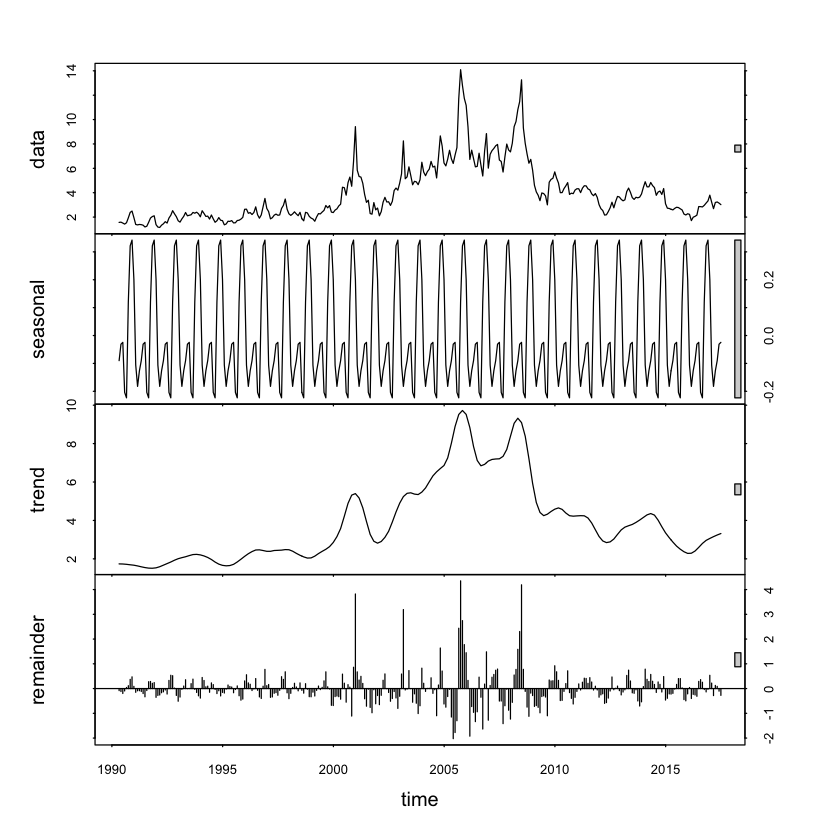

In [8]:
# Decompose time series

decomp = stl(monthly_ts, s.window="periodic")
plot(decomp)

We clearely see seasonality in the residual plot. For Time Series analysis, we need to convert it into a stationary series.

The ***augmented Dickey-Fuller (ADF)*** test is a formal statistical test for stationarity. The null hypothesis assumes that the series is non-stationary. ADF procedure tests whether the change in Y can be explained by lagged value and a linear trend. If contribution of the lagged value to the change in Y is non-significant and there is a presence of a trend component, the series is non-stationary and null hypothesis will not be rejected.

In [9]:
adf.test(monthly_ts, alternative = "stationary")


	Augmented Dickey-Fuller Test

data:  monthly_ts
Dickey-Fuller = -2.6388, Lag order = 6, p-value = 0.3072
alternative hypothesis: stationary


This means that the series is not stationary. Usually, non-stationary series can be corrected by a simple transformation such as differencing. Differencing the series can help in removing its trend or cycles. The idea behind differencing is that, if the original data series does not have constant properties over time, then the change from one period to another might. 


	Augmented Dickey-Fuller Test

data:  monthly_dff1
Dickey-Fuller = -7.4249, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


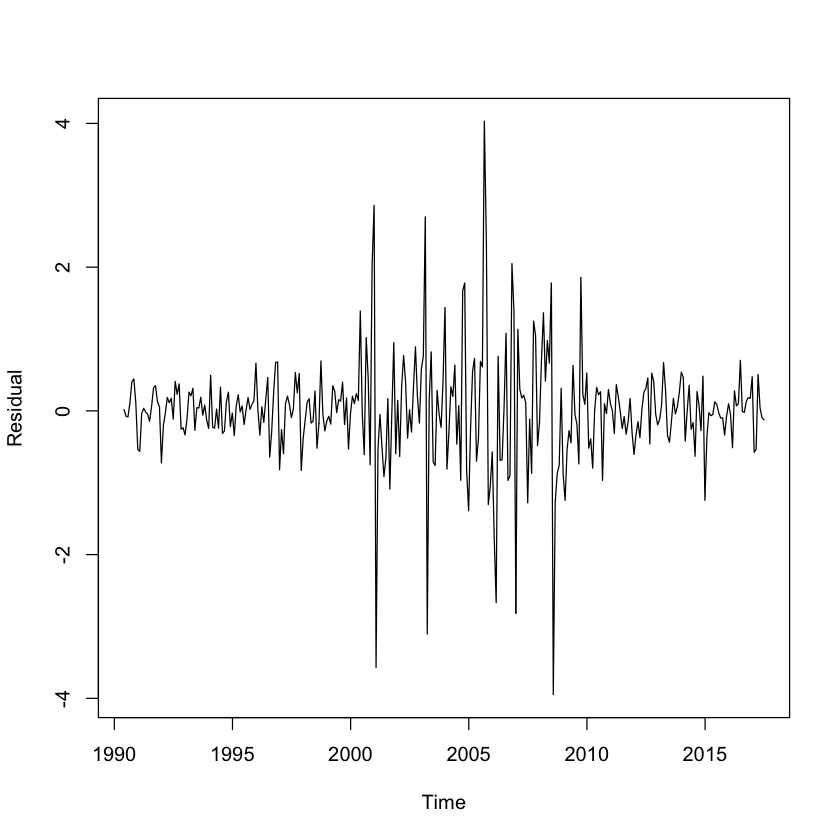

In [11]:
monthly_dff1 = diff(monthly_ts, differences = 1)
adf.test(monthly_dff1, alternative = "stationary")

plot(monthly_dff1, ylab="Residual")

In [12]:
summary(monthly_dff1)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-3.949000 -0.280000  0.014000  0.004463  0.275000  4.029000 

The mean is close to 0 and Dickey-Fuller Test suggests that the null hypothesis can be rejected. That is TS is close to being a stationary and differencing parameter ***d = 1***

*** Autocorrelations and Choosing Model Order ***

Autocorrelation plots (also known as ACF or the auto correlation function) are a useful visual tool in determining whether a series is stationary. These plots can also help to choose the order parameters for ARIMA model. If the series is correlated with its lags then, generally, there are some trend or seasonal components and therefore its statistical properties are not constant over time.

ACF plots display correlation between a series and its lags. In addition to suggesting the order of differencing, ACF plots can help in determining the order of the MA (q) model. Partial autocorrelation plots (PACF), as the name suggests, display correlation between a variable and its lags that is not explained by previous lags. PACF plots are useful when determining the order of the AR(p) model.

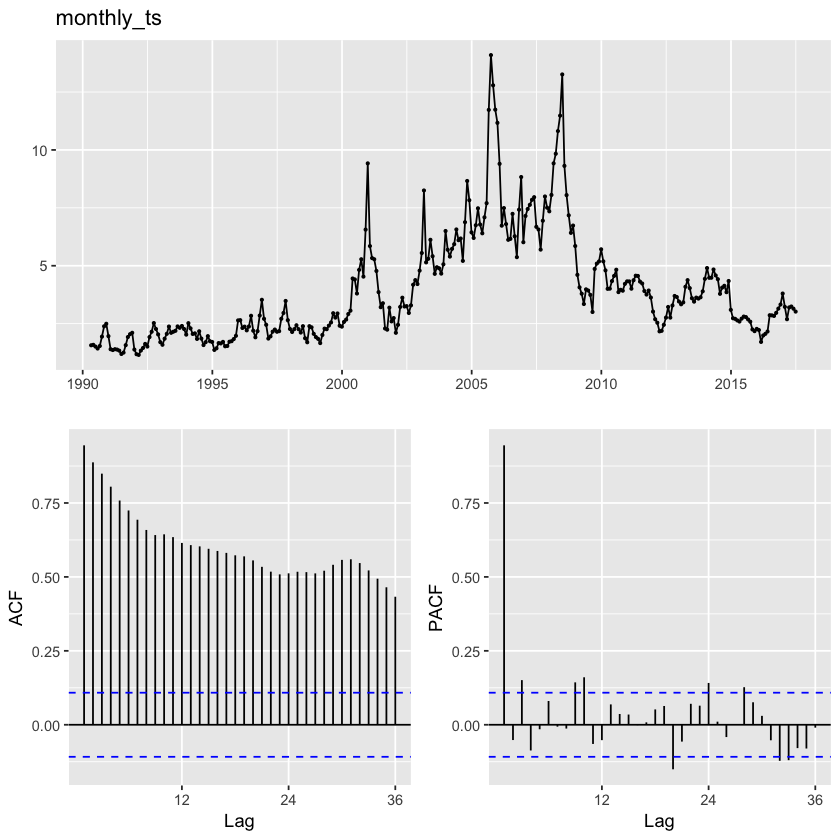

In [13]:
# Inspect ACF and PACF

ggtsdisplay(monthly_ts)

#### Auto-correlation of residual

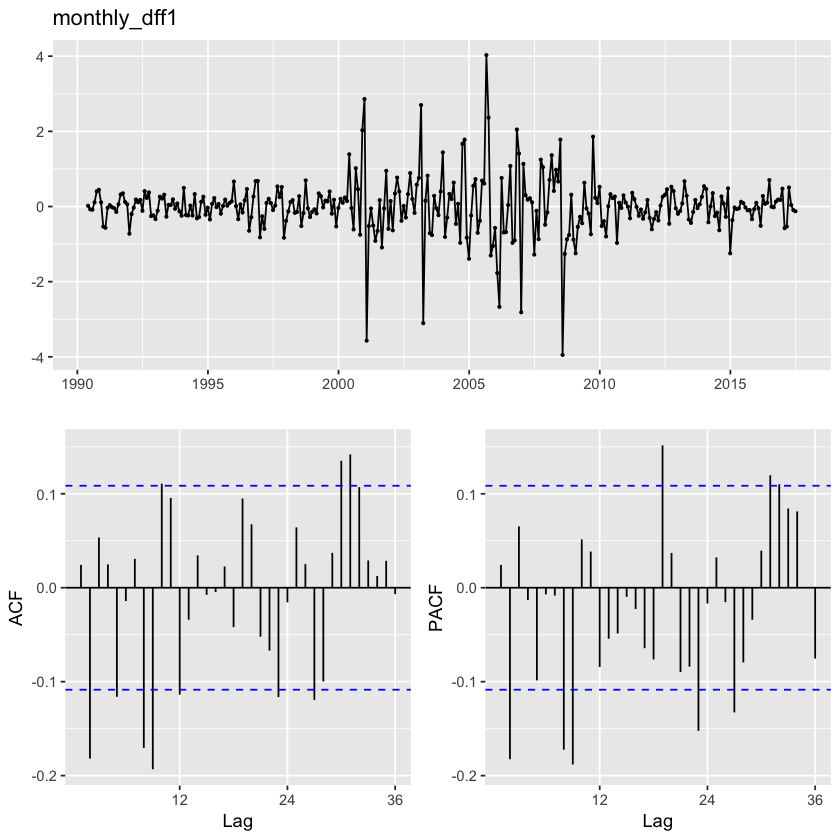

In [14]:
ggtsdisplay(monthly_dff1)

There are significant auto correlations at lag 2 and 9 and beyond. Partial correlation plots show a significant spike at lag 8 and 9. This suggests that we might want to test models with AR or MA components of order 2, 8, or 9. 


Call:
arima(x = monthly_ts, order = c(9, 1, 9))

Coefficients:
          ar1      ar2      ar3      ar4      ar5     ar6     ar7      ar8
      -0.1695  -0.6962  -0.4243  -0.3223  -0.1064  0.0403  0.2991  -0.1286
s.e.   0.0833   0.0694   0.0936   0.1124   0.1096  0.1051  0.0933   0.0687
         ar9     ma1     ma2     ma3     ma4      ma5      ma6      ma7
      0.5029  0.1666  0.5869  0.4262  0.2385  -0.0723  -0.1164  -0.4472
s.e.  0.0672  0.0639  0.0601  0.0678  0.0828   0.0746   0.0778   0.0668
          ma8      ma9
      -0.0512  -0.8598
s.e.   0.0486   0.0664

sigma^2 estimated as 0.438:  log likelihood = -334.37,  aic = 706.75

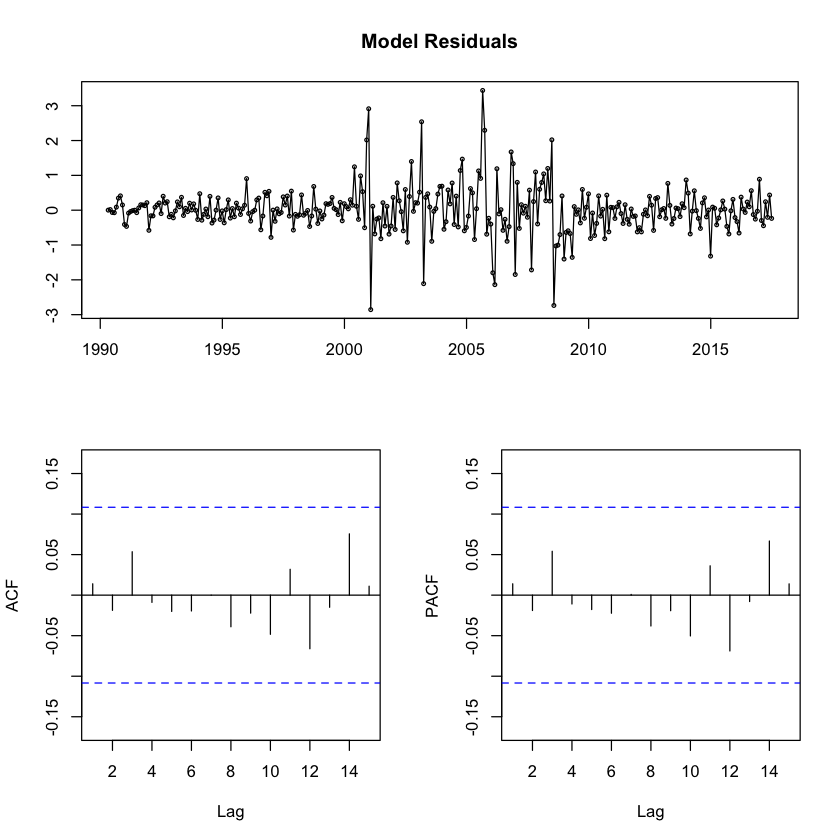

In [15]:
fit_monthly = arima(monthly_ts, order=c(9,1,9))
fit_monthly

tsdisplay(residuals(fit_monthly), lag.max=15, main='Model Residuals')

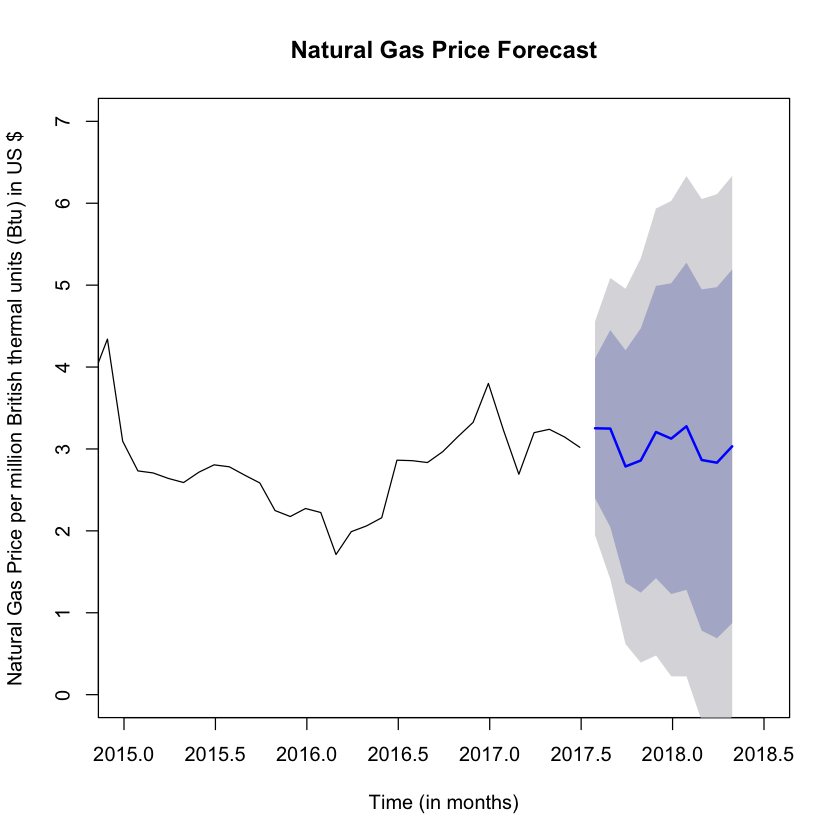

In [28]:
fcast_monthly <- forecast(fit_monthly, h=10)
plot(fcast_monthly,xlim = c(2015, 2018.5), ylim = c(0,7), xlab = "Time (in months)", 
     ylab = "Natural Gas Price per million British thermal units (Btu) in US $", 
    main = "Natural Gas Price Forecast")

In [17]:
fcast_monthly

         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
2017.576       3.252341 2.3994580 4.105224  1.9479690 4.556713
2017.659       3.248567 2.0465106 4.450623  1.4101805 5.086953
2017.743       2.786360 1.3679075 4.204813  0.6170239 4.955697
2017.826       2.859042 1.2459766 4.472107  0.3920716 5.326012
2017.909       3.206730 1.4224847 4.990975  0.4779623 5.935498
2017.993       3.125848 1.2286577 5.023038  0.2243458 6.027350
2018.076       3.276988 1.2798304 5.274146  0.2225989 6.331378
2018.159       2.864792 0.7813365 4.948247 -0.3215781 6.051162
2018.243       2.832482 0.6894164 4.975548 -0.4450542 6.110019
2018.326       3.031888 0.8727347 5.191041 -0.2702519 6.334027

# Exponential Smoothing

In [29]:
exp_model <- HoltWinters(monthly_ts)

exp_model

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = monthly_ts)

Smoothing parameters:
 alpha: 1
 beta : 0
 gamma: 0

Coefficients:
           [,1]
a    3.41437847
b   -0.01977142
s1  -0.30129514
s2   0.03741319
s3   0.39962153
s4   0.64737153
s5   0.77549653
s6   0.26424653
s7  -0.28012847
s8  -0.30933681
s9  -0.27408681
s10 -0.27517014
s11 -0.28975347
s12 -0.39437847

In [32]:
exp_pred <- predict(exp_model, 15, prediction.interval = TRUE)
exp_pred

fit,upr,lwr
3.093312,4.620280,1.5663436
3.412249,5.571708,1.2527895
3.754686,6.399472,1.1098990
3.982664,7.036601,0.9287277
4.091018,7.505423,0.6766129
3.559997,7.300290,-0.1802968
2.995850,7.035829,-1.0441284
2.946870,7.265789,-1.3720483
2.962349,7.543254,-1.6185561
2.941494,7.770192,-1.8872037


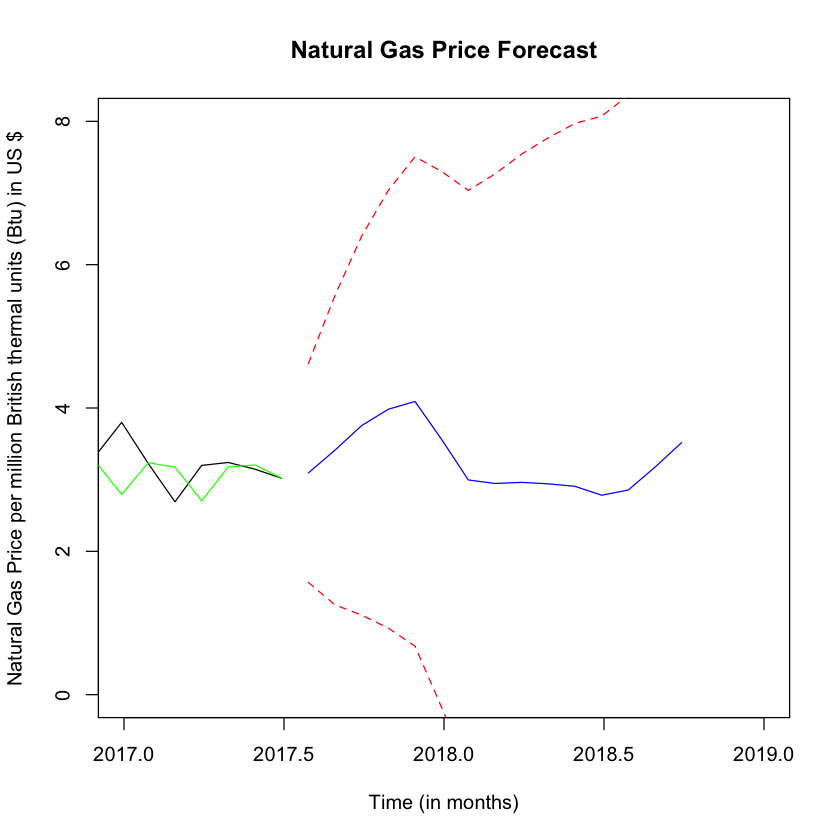

In [35]:
plot.ts(monthly_ts, xlim = c(2017, 2019), ylim = c(0,8), xlab = "Time (in months)", 
        ylab = "Natural Gas Price per million British thermal units (Btu) in US $",
       main = "Natural Gas Price Forecast")
lines(exp_model$fitted[,1], col = "green")
lines(exp_pred[,1], col = "blue")
lines(exp_pred[,2], col = "red", lty = 2)
lines(exp_pred[,3], col = "red", lty = 2)

***Conclusion***: The Natural gas price per 1 million Btu will reach close to $4.